# Quantum Kernel Estimation

## Code of Conduct

This notebook is modified from https://github.com/qiskit-community/qiskit-machine-learning/tree/main/docs/tutorials
from 03_quantum_kernel

This code is a part of Qiskit
© Copyright IBM 2017, 2024.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.

## 1. Introduction

### 1.1. Kernel Methods for Machine Learning

Kernel methods are a collection of pattern analysis algorithms that use kernel functions to operate in a high-dimensional feature space. The best-known application of kernel methods is in **Support Vector Machines (SVMs)**, supervised learning algorithms commonly used for classification tasks. The main goal of SVMs is to find decision boundaries to separate a given set of data points into classes. When these data spaces are not linearly separable, SVMs can benefit from the use of kernels to find these boundaries.

Formally, decision boundaries are hyperplanes in a high dimensional space. The kernel function implicitly maps input data into this higher dimensional space, where it can be easier to solve the initial problem. In other words, kernels may allow data distributions that were originally non-linearly separable to become a linearly separable problem. This is an effect known as the "kernel trick".

There are use-cases for kernel-based unsupervised algorithms too, for example, in the context of clustering. **Spectral Clustering** is a technique where data points are treated as nodes of a graph, and the clustering task is viewed as a graph partitioning problem where nodes are mapped to a space where they can be easily segregated to form clusters.

### 1.2. Kernel Functions

Mathematically, kernel functions follow:

$k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle$

where 
* $k$ is the kernel function
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $f$ is a map from $n$-dimension to $m$-dimension space and 
* $\langle a,b \rangle$ denotes the inner product

When considering finite data, a kernel function can be represented as a matrix: 

$K_{ij} = k(\vec{x}_i,\vec{x}_j)$.

### 1.3. Quantum Kernels

The main idea behind quantum kernel machine learning is to leverage quantum feature maps to perform the kernel trick. In this case, the quantum kernel is created by mapping a classical feature vector $\vec{x}$ to a Hilbert space using a quantum feature map $\phi(\vec{x})$. Mathematically:

$K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$

where 
* $K_{ij}$ is the kernel matrix
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $\phi(\vec{x})$ is the quantum feature map
* $\left| \langle a|b \rangle \right|^{2}$ denotes the overlap of two quantum states $a$ and $b$

Quantum kernels can be plugged into common classical kernel learning algorithms such as SVMs or clustering algorithms, as you will see in the examples below. They can also be leveraged in new quantum kernel methods like [QSVC](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.QSVC.html) class  provided by `qiskit-machine-learning` which is explored in this tutorial, and other methods as shown in later tutorials on [Pegasos QSVC](07_pegasos_qsvc.ipynb) and [Quantum Kernel Training](08_quantum_kernel_trainer.ipynb).

***

Before introducing any example, we set up the global seed to ensure reproducibility:

In [1]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 12345

## 2. Classification

This section illustrates a quantum kernel classification workflow using `qiskit-machine-learning`.

### 2.1. Defining the dataset

For this example, we will use the _ad hoc dataset_ as described in the reference [paper](https://arxiv.org/pdf/1804.11326.pdf). 

We can define the dataset dimension and get our train and test subsets:

In [50]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=140,
    test_size=70,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

This dataset is two-dimensional, the two features are represented by the $x$ and $y$ coordinates, and it has two class labels: A and B. We can plot it and see what the distribution looks like. We define utility functions to plot the dataset.

In [51]:
import matplotlib.pyplot as plt
import numpy as np


def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )

    # A train plot
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

Now we actually plot the dataset for classification:

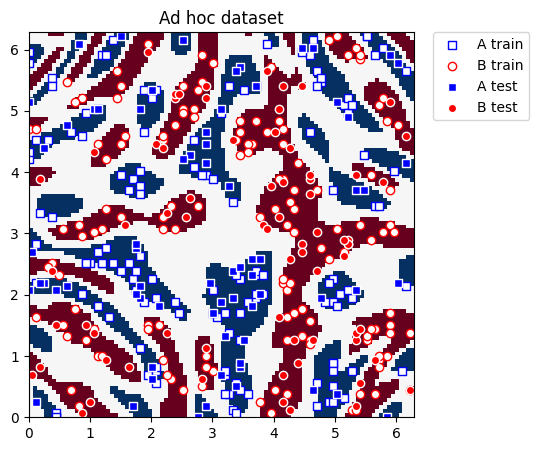

In [52]:
plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

### 2.2. Defining the quantum kernel

The next step is to create a quantum kernel instance that will help classify this data. 

We use the [FidelityQuantumKernel](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.kernels.FidelityQuantumKernel.html) class, and pass two input arguments to its constructor: 

1. `feature_map`: in this case, a two-qubit [ZZFeatureMap](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap).

2. `fidelity`: in this case, the [ComputeUncompute](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.state_fidelities.ComputeUncompute.html) fidelity subroutine that leverages the [Sampler](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Sampler) primitive.

**NOTE:** If you don't pass a `Sampler` or `Fidelity` instance, then the instances of the reference `Sampler` and `ComputeUncompute` classes (found in `qiskit.primitives`) will be created by default.

In [53]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

### 2.3. Classification with SVC
The quantum kernel can now be plugged into classical kernel methods, such as the [SVC](https://scikit-learn.org/stable/modules/svm.html) algorithm from `scikit-learn`. This algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways:

1. by providing the kernel as a **callable function**
2. by precomputing the **kernel matrix**

#### Kernel as a callable function

We define a SVC model and directly pass the `evaluate` function of the quantum kernel as a callable. Once the model is created, we train it by calling the `fit` method on the training dataset and evaluate the model for accuracy with `score`.

In [54]:
from sklearn.svm import SVC

adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

adhoc_svc.fit(train_features, train_labels)

adhoc_score_callable_function = adhoc_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

Callable kernel classification test score: 1.0


#### Precomputed kernel matrix

Instead of passing a function of the quantum kernel as a callable, we can also precompute training and testing kernel matrices before passing them to the `scikit-learn` `SVC` algorithm. 

To extract the train and test matrices, we can call `evaluate` on the previously defined kernel and visualize them graphically as follows:

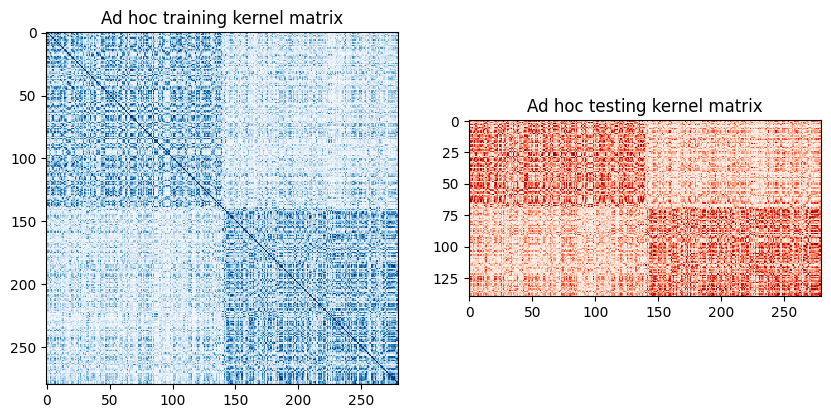

In [55]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

To use these matrices, we set the `kernel` parameter of a new `SVC` instance to `"precomputed"`. We train the classifier by calling `fit` with the training matrix and training dataset. Once the model is trained, we evaluate it using the test matrix on the test dataset.

In [8]:
adhoc_svc = SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, train_labels)

adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed kernel classification test score: 1.0


# 3 compare with RBf kernel

In [56]:
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
X =train_features

y =  train_labels

clf = svm.SVC(kernel="rbf")
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma':[0.0001, 0.001, 0.01, 1, 10, 100, 1000]}
 
# perform grid search
svm = SVC(kernel='rbf')
grid_search = GridSearchCV(svm, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1)
grid_search.fit(X, y)
 
print(
    "Best parameters are {} \nScore : {}%".format(
        grid_search.best_params_, grid_search.best_score_*100)
)
clf_best = SVC(kernel='rbf', C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'])
predicted=clf_best.fit(X, y)
accuracy=clf_best.score(test_features, test_labels)
print(accuracy)

Best parameters are {'C': 10, 'gamma': 10} 
Score : 86.05582246625487%
0.9357142857142857


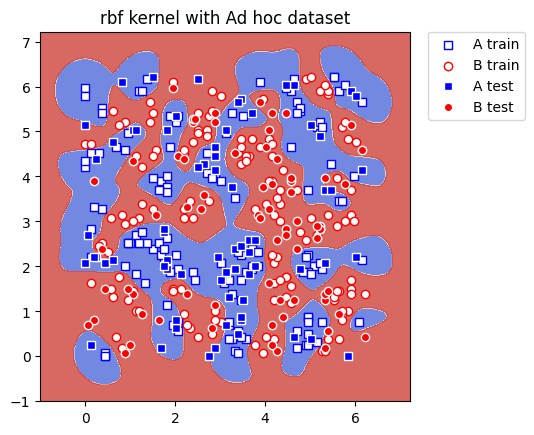

In [57]:

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out



fig, ax = plt.subplots()
# title for the plots
title = ('Decision boundary of rbf ')
# Set-up grid for plotting.
X0, X1 = X[:, 0],X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf_best, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

# B train plot
plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

# A test plot
plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

# B test plot
plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("rbf kernel with Ad hoc dataset")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()


In [45]:
from sklearn.datasets import make_moons
from sklearn import svm
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
interval_min = 0
interval_max = 2 * np.pi
X [:,0]= (X [:,0] - np.min(X [:,0])) / (np.max(X [:,0]) - np.min(X [:,0])) * (interval_max - interval_min) + interval_min
X [:,1]= (X [:,1] - np.min(X [:,1])) / (np.max(X [:,1]) - np.min(X [:,1])) * (interval_max - interval_min) + interval_min
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = svm.SVC(kernel="rbf")
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma':[0.0001, 0.001, 0.01, 1, 10, 100, 1000]}
 
# perform grid search
svm = SVC(kernel='rbf')
grid_search = GridSearchCV(svm, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
 
print(
    "Best parameters are {} \nScore : {}%".format(
        grid_search.best_params_, grid_search.best_score_*100)
)
clf_best = SVC(kernel='rbf', C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'])
predicted=clf_best.fit(X_train, y_train)
accuracy=clf_best.score(X_test,y_test)
print(accuracy)

Best parameters are {'C': 1, 'gamma': 1} 
Score : 96.27946127946126%
0.9696969696969697


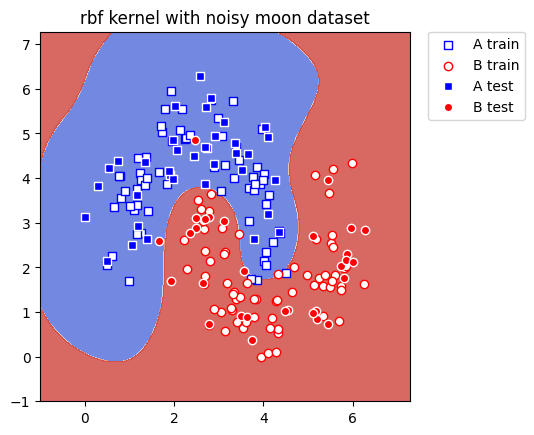

In [46]:

fig, ax = plt.subplots()
# title for the plots
title = ('Decision boundary of rbf ')
# Set-up grid for plotting.
X0, X1 = X[:, 0],X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf_best, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plot_features(plt, X_train, y_train, 0, "s", "w", "b", "A train")

# B train plot
plot_features(plt, X_train, y_train, 1, "o", "w", "r", "B train")

# A test plot
plot_features(plt, X_test,y_test, 0, "s", "b", "w", "A test")

# B test plot
plot_features(plt, X_test,y_test, 1, "o", "r", "w", "B test")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("rbf kernel with noisy moon dataset")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()


In [4]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
adhoc_dimension = 2
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

In [10]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
C={0.001, 0.01, 0.1, 1, 10, 100, 1000}
adhoc_score_callable_function=0
C_optimal=0
adhoc_best=0
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
interval_min = 0
interval_max = 2 * np.pi
X [:,0]= (X [:,0] - np.min(X [:,0])) / (np.max(X [:,0]) - np.min(X [:,0])) * (interval_max - interval_min) + interval_min
X [:,1]= (X [:,1] - np.min(X [:,1])) / (np.max(X [:,1]) - np.min(X [:,1])) * (interval_max - interval_min) + interval_min
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
from sklearn.svm import SVC
for c in C:
    adhoc_svc = SVC(kernel=adhoc_kernel.evaluate,C=c)

    adhoc_svc.fit(X_train, y_train)
    if adhoc_score_callable_function<=adhoc_svc.score(X_test,y_test):
        adhoc_score_callable_function = adhoc_svc.score(X_test,y_test)
        C_optimal=c
        adhoc_best=adhoc_svc
print(f"Optimal C is {C_optimal}")
print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

Optimal C is 100
Callable kernel classification test score: 0.5454545454545454


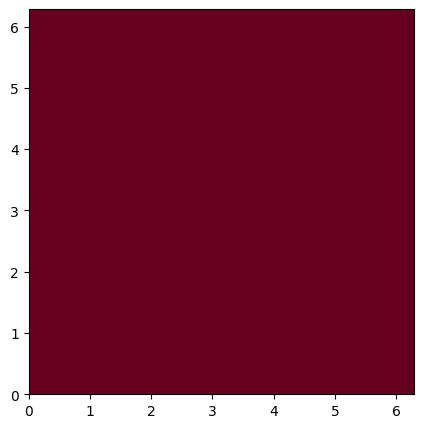

In [13]:
import matplotlib.pyplot as plt

plot_contours(ax, clf_best, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plot_features(plt, X_train, y_train, 0, "s", "w", "b", "A train")

# B train plot
plot_features(plt, X_train, y_train, 1, "o", "w", "r", "B train")

# A test plot
plot_features(plt, X_test,y_test, 0, "s", "b", "w", "A test")

# B test plot
plot_features(plt, X_test,y_test, 1, "o", "r", "w", "B test")
plot_dataset(X_train, y_train, X_test, y_test,200)